In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torchvision.transforms as transforms
import os
import shutil
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import random
import torchvision.models as models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from PIL import Image
from PIL import ImageOps
from tqdm import tqdm

In [2]:
import os

print(os.cpu_count())


64


In [3]:
class ResizeByLongerSideWithRatio:
    def __init__(self, size, fill_color=0):
        self.size = size  # The fixed size for the longer side
        self.fill_color = fill_color  # Padding color (default: black)

    def __call__(self, image):
        w, h = image.size  # Get original width and height
        ratio = w/h
        target_w, target_h = self.size
        target_ratio = target_w/target_h
        if target_ratio <= ratio:
            # Scale height to maintain aspect ratio
            new_w, new_h = target_w, int((h/w)*target_w)
            padding_h = target_h-new_h
            padding_w = 0
        
        else:
            # Scale width to maintain aspect ratio
            new_w, new_h = int((w/h)*target_h), target_h
            padding_w = target_w - new_w
            padding_h = 0
        # Resize the image
        
        #image = self.binarize(image)
        
        image = image.resize((new_w, new_h))
        
        left = random.randint(0,padding_w)
        top = random.randint(0,padding_h)
        right = padding_w-left
        bot = padding_h-top
        padding = (left,top,right,bot)
        
        image = ImageOps.expand(image, border=padding, fill=self.fill_color)
        return image
    def binarize(self, image):
        image = np.array(image)
        image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
        image_gray = cv2.medianBlur(image_gray,5)
        image_gray = cv2.normalize(image_gray, None, alpha=0, beta=350, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        BLOCK_SIZE = 11
        CONSTANT = 10
        
        image = cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,BLOCK_SIZE,CONSTANT)
        image = Image.fromarray(image.astype(np.uint8))
        
        return image
   

In [4]:
class ResizeByLongerSideWithRatioNoRandom:
    def __init__(self, size, fill_color=0):
        self.size = size  # The fixed size for the longer side
        self.fill_color = fill_color  # Padding color (default: black)

    def __call__(self, image):
        w, h = image.size  # Get original width and height
        ratio = w/h
        target_w, target_h = self.size
        target_ratio = target_w/target_h
        if target_ratio <= ratio:
            # Scale height to maintain aspect ratio
            new_w, new_h = target_w, int((h/w)*target_w)
            padding_h = target_h-new_h
            padding_w = 0
        
        else:
            # Scale width to maintain aspect ratio
            new_w, new_h = int((w/h)*target_h), target_h
            padding_w = target_w - new_w
            padding_h = 0
        # Resize the image
        
        #image = self.binarize(image)
        
        image = image.resize((new_w, new_h))
        left = padding_w//2
        top = padding_h//2
        right = padding_w-left
        bot = padding_h-top
        padding = (left,top,right,bot)
        
        image = ImageOps.expand(image, border=padding, fill=self.fill_color)
        return image
    def binarize(self, image):
        image = np.array(image)
        image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
        image_gray = cv2.medianBlur(image_gray,5)
        image_gray = cv2.normalize(image_gray, None, alpha=0, beta=350, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        BLOCK_SIZE = 11
        CONSTANT = 10
        
        image = cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,BLOCK_SIZE,CONSTANT)
        image = Image.fromarray(image.astype(np.uint8))
        
        return image

In [5]:
from torchvision import transforms
from PIL import ImageOps

class Invert:
    def __call__(self, img):
        return ImageOps.invert(img)



In [7]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms

class LaplacianSharpen:
    def __init__(self, amount=3):
        self.amount = amount

    def __call__(self, img):
        img_np = np.array(img)

        if img_np.ndim == 3 and img_np.shape[2] == 3:
            sharpened_channels = []
            for i in range(3):class SobelEdgeDetection:
    def __init__(self):
        # Define Sobel kernels for edge detection
        self.kernel_x = torch.tensor([[-1., 0., 1.],
                                      [-2., 0., 2.],
                                      [-1., 0., 1.]]).view(1, 1, 3, 3)
        self.kernel_y = torch.tensor([[-1., -2., -1.],
                                      [ 0.,  0.,  0.],
                                      [ 1.,  2.,  1.]]).view(1, 1, 3, 3)

    def __call__(self, tensor):
        # If RGB, convert to grayscale
        if tensor.dim() == 3 and tensor.shape[0] == 3:
            tensor = 0.2989 * tensor[0] + 0.5870 * tensor[1] + 0.1140 * tensor[2]
            tensor = tensor.unsqueeze(0)  # [1, H, W]

        tensor = tensor.unsqueeze(0)  # Add batch dimension: [1, 1, H, W]

        # Reflective padding to preserve borders
        tensor = F.pad(tensor, (1, 1, 1, 1), mode='reflect')

        # Apply Sobel filters
        edge_x = F.conv2d(tensor, self.kernel_x)
        edge_y = F.conv2d(tensor, self.kernel_y)

        # Compute gradient magnitude
        edge = torch.sqrt(edge_x ** 2 + edge_y ** 2)

        # Normalize to [0, 1]
        edge = (edge - edge.min()) / (edge.max() - edge.min() + 1e-6)

        # Remove batch dimension, keep channel: [1, H, W]
        edge = edge.squeeze(0)

        # Repeat the grayscale edge map into 3 channels: [3, H, W]
        edge_rgb = edge.repeat(3, 1, 1)

        return edge_rgb

                lap = cv2.Laplacian(img_np[:, :, i], cv2.CV_64F)
                sharp = img_np[:, :, i].astype(np.float64) + self.amount * lap
                sharp = np.clip(sharp, 0, 255)
                sharpened_channels.append(sharp.astype(np.uint8))
            sharpened = np.stack(sharpened_channels, axis=2)
        else:
            laplacian = cv2.Laplacian(img_np, cv2.CV_64F)
            sharpened = img_np.astype(np.float64) + self.amount * laplacian
            sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

        return Image.fromarray(sharpened)





IndentationError: unindent does not match any outer indentation level (<tokenize>, line 58)

In [8]:
import torch
import torch.nn.functional as F
class SobelEdgeDetection:
    def __init__(self):
        # Define Sobel kernels for edge detection
        self.kernel_x = torch.tensor([[-1., 0., 1.],
                                      [-2., 0., 2.],
                                      [-1., 0., 1.]]).view(1, 1, 3, 3)
        self.kernel_y = torch.tensor([[-1., -2., -1.],
                                      [ 0.,  0.,  0.],
                                      [ 1.,  2.,  1.]]).view(1, 1, 3, 3)

    def __call__(self, tensor):
        # If RGB, convert to grayscale
        if tensor.dim() == 3 and tensor.shape[0] == 3:
            tensor = 0.2989 * tensor[0] + 0.5870 * tensor[1] + 0.1140 * tensor[2]
            tensor = tensor.unsqueeze(0)  # [1, H, W]

        tensor = tensor.unsqueeze(0)  # Add batch dimension: [1, 1, H, W]

        # Reflective padding to preserve borders
        tensor = F.pad(tensor, (1, 1, 1, 1), mode='reflect')

        # Apply Sobel filters
        edge_x = F.conv2d(tensor, self.kernel_x)
        edge_y = F.conv2d(tensor, self.kernel_y)

        # Compute gradient magnitude
        edge = torch.sqrt(edge_x ** 2 + edge_y ** 2)

        # Normalize to [0, 1]
        edge = (edge - edge.min()) / (edge.max() - edge.min() + 1e-6)

        # Remove batch dimension, keep channel: [1, H, W]
        edge = edge.squeeze(0)

        # Repeat the grayscale edge map into 3 channels: [3, H, W]
        edge_rgb = edge.repeat(3, 1, 1)

        return edge_rgb


In [9]:

#from CustomTransforms import ResizeByLongerSideWithRatio
train_transform = transforms.Compose([
    #Invert(),
    
    ResizeByLongerSideWithRatioNoRandom(size=(224,224)),
    
    #LaplacianSharpen(),
    #ResizeByLongerSideWithRatioNoRandom(size=(224,224)),# Resize based on longer side
    transforms.ToTensor(),
    #SobelEdgeDetection(),
    #transforms.RandomApply([transforms.GaussianBlur(5)], p=0.3),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),  # Normalize
    #transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize
    #transforms.Lambda(lambda x: 1 - x)  # Invert pixel values in tensor
    #transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

val_transform = transforms.Compose([
    #Invert(),
    #LaplacianSharpen(),
    ResizeByLongerSideWithRatioNoRandom(size=(224,224)),# Resize based on longer side
    
    transforms.ToTensor(),
    #SobelEdgeDetection(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),  # Normalize
    #transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize
])

In [10]:

def remove_checkpoints(base_dir):
    for root, dirs, _ in os.walk(base_dir):
        for folder in dirs:
            if folder == ".ipynb_checkpoints":
                folder_path = os.path.join(root, folder)
                shutil.rmtree(folder_path)
                print(f"Removed: {folder_path}")

# Replace with your dataset directory
data_dir = "cross_out_dataset"
remove_checkpoints(data_dir)

In [11]:


class FilteredImageFolder(Dataset):
    def __init__(self, root, transform=None, min_size=20):
        self.root_dir = root        
        self.transform = transform
        self.min_size = min_size
        self.image_paths, self.labels = self._filter_and_label_images()

    def _filter_and_label_images(self):
        image_paths = []
        labels = []
        class_names = sorted(os.listdir(self.root_dir))  # Get folder names as labels
        class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                try:
                    img = Image.open(img_path)
                    width, height = img.size
                    if width >= self.min_size and height >= self.min_size:
                        image_paths.append(img_path)
                        labels.append(class_to_idx[class_name])  # Assign label based on folder
                except:
                    print(f"Skipping corrupted file: {img_path}")
        print(class_to_idx)
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)

        return img, label  # Returning (image, label) tuple

In [12]:

data_dir = "cross_out_dataset"  # Update this with your dataset path

train_dataset = FilteredImageFolder(root=f"{data_dir}/train/images", transform=train_transform)
val_dataset = FilteredImageFolder(root=f"{data_dir}/val/images", transform=val_transform)
test_dataset = FilteredImageFolder(root=f"{data_dir}/test/images", transform=val_transform)


Skipping corrupted file: cross_out_dataset/train/images/CLEAN/gt.txt
{'CLEAN': 0, 'CROSS': 1, 'DIAGONAL': 2, 'DOUBLE_LINE': 3, 'SCRATCH': 4, 'SINGLE_LINE': 5, 'WAVE': 6, 'ZIG_ZAG': 7}
Skipping corrupted file: cross_out_dataset/val/images/CLEAN/gt.txt
{'CLEAN': 0, 'CROSS': 1, 'DIAGONAL': 2, 'DOUBLE_LINE': 3, 'SCRATCH': 4, 'SINGLE_LINE': 5, 'WAVE': 6, 'ZIG_ZAG': 7}
Skipping corrupted file: cross_out_dataset/test/images/CLEAN/gt.txt
Skipping corrupted file: cross_out_dataset/test/images/CROSS/gt.txt
Skipping corrupted file: cross_out_dataset/test/images/DIAGONAL/gt.txt
Skipping corrupted file: cross_out_dataset/test/images/DOUBLE_LINE/gt.txt
Skipping corrupted file: cross_out_dataset/test/images/SCRATCH/gt.txt
Skipping corrupted file: cross_out_dataset/test/images/SINGLE_LINE/gt.txt
Skipping corrupted file: cross_out_dataset/test/images/WAVE/gt.txt
Skipping corrupted file: cross_out_dataset/test/images/ZIG_ZAG/gt.txt
{'CLEAN': 0, 'CROSS': 1, 'DIAGONAL': 2, 'DOUBLE_LINE': 3, 'SCRATCH': 4, 

In [29]:

data_dir = "Eget_test_set"  # Update this with your dataset path

train_dataset = datasets.ImageFolder(root=f"{data_dir}", transform=train_transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}", transform=val_transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}", transform=val_transform)


In [88]:
"""
from PIL import Image

for root, _, files in os.walk("cross_out_dataset/val/images"):
    for file in files:
        try:
            Image.open(os.path.join(root, file)).verify()
        except Exception as e:
            print(f"Corrupted file: {file} - {e}")
"""

'\nfrom PIL import Image\n\nfor root, _, files in os.walk("cross_out_dataset/val/images"):\n    for file in files:\n        try:\n            Image.open(os.path.join(root, file)).verify()\n        except Exception as e:\n            print(f"Corrupted file: {file} - {e}")\n'

In [29]:
print(test_dataset.class_to_idx.items())
print(val_dataset.classes)

AttributeError: 'FilteredImageFolder' object has no attribute 'class_to_idx'

In [11]:
import wandb
wandb.init(project="Group_19_lab1",name="RESNET18_SHARP")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wilwoh-2 (ertveh-4-lule-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


0
torch.Size([3, 224, 224])


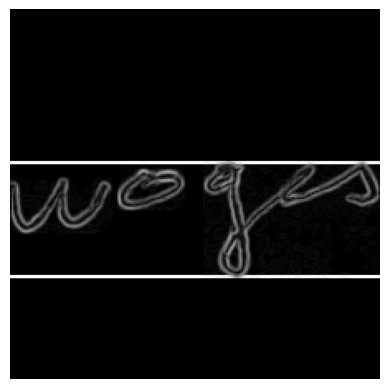

In [72]:
# Access one image and its label from the dataset

#i = random.randint(0,1000)

i = 100

image, label = train_dataset[i]  # Get the first image-label pair
print(label)
print(image.shape)
# Denormalize the image for visualization (convert back to [0,1] range)
image = image * 0.5 + 0.5  # Reverse normalization

# Display the image
plt.imshow(image.permute(1, 2, 0))  # Permute tensor dimensions (C, H, W → H, W, C)
plt.axis("off")  # Turn off axes for clarity
plt.show()

In [13]:
BATCH_SIZE = 64
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 8)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 353482, Validation: 55033, Test: 151032


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(BasicBlock, self).__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


class ResNet6(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet6, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = BasicBlock(64, 128, downsample=True)
        self.layer2 = BasicBlock(128, 256, downsample=True)
        #self.layer3 = BasicBlock(256, 256, downsample=True)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # [batch, 64, 112, 112]
        x = self.maxpool(x)                     # [batch, 64, 56, 56]
        x = self.layer1(x)                      # [batch, 128, 28, 28]
        x = self.layer2(x)                      # [batch, 256, 14, 14]
        #x = self.layer3(x)
        x = self.avgpool(x)                     # [batch, 256, 1, 1]
        x = torch.flatten(x, 1)
        x = self.fc(x)                          # [batch, num_classes]
        return x

model = ResNet6(num_classes=8)

In [23]:

# Load ResNet18 pretrained model
model = models.resnet18(pretrained=True)

# Modify the fully connected layer for 8 classes
num_classes = 8
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Check the model architecture

# Modify the first convolutional layer to accept single-channel input
#model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#model = replace_all_conv_layers(model)
#model.conv1 = nn.Conv2d(3, 64, kernel_size=(3,7), stride=(1,2), padding=(1,3), bias=False)
#model.maxpool = nn.AvgPool2d(kernel_size=2, stride=2)
#model.maxpool = nn.AvgPool2d(2,2)

In [15]:
import torch
print(torch.cuda.is_available())  # Returns True if a GPU is available
# Specify the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model to the device
model = model.to(device)

True


In [17]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

In [25]:
epochs = 10
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=epochs
)


for epoch in range(epochs):
    tot_train_loss = 0
    tot_val_loss = 0

    model.train()
    batch_id = 0
    best_val_loss = 100000
    for batch in tqdm(train_loader):
        
        
        inp = batch[0].to(device)
        label = batch[1].to(device)
        output = model(inp)

        loss = criterion(output,label)
        tot_train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        scheduler.step()
        
    model.eval()
    total_samples = 0
    batch_id = 0
    for batch in val_loader:
        optimizer.zero_grad()

        inp = batch[0].to(device)
        label = batch[1].to(device)
        output = model(inp)

        loss = criterion(output,label)
        tot_val_loss += loss.item()
        
    avg_train_loss = tot_train_loss/len(train_loader)
    avg_val_loss = tot_val_loss/len(val_loader)
    print("Epoch: ",epoch,"Train loss: ",avg_train_loss,"Val loss: ",avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_model = model
        best_val_loss = avg_val_loss
    print()
    current_lr = optimizer.param_groups[0]['lr']
    print("Current lr: ", current_lr)
    wandb.log({
        "train_loss":avg_train_loss,
        "val_loss":avg_val_loss,
        "lr": current_lr
    })
    torch.cuda.empty_cache()

100%|██████████| 5524/5524 [07:34<00:00, 12.16it/s]


Epoch:  0 Train loss:  2.197420693863828 Val loss:  2.192183162168015

Current lr:  0.0002800262699769715


100%|██████████| 5524/5524 [07:27<00:00, 12.33it/s]


Epoch:  1 Train loss:  2.1974082809052202 Val loss:  2.196227108323297

Current lr:  0.0007600525370784775


100%|██████████| 5524/5524 [07:32<00:00, 12.21it/s]


Epoch:  2 Train loss:  2.1979368543771622 Val loss:  2.194316920430161

Current lr:  0.0009999999983498075


100%|██████████| 5524/5524 [07:21<00:00, 12.50it/s]


Epoch:  3 Train loss:  2.197394131750926 Val loss:  2.1986023069814196

Current lr:  0.0009504670050933527


100%|██████████| 5524/5524 [07:21<00:00, 12.53it/s]


Epoch:  4 Train loss:  2.198175475853755 Val loss:  2.1977156417314396

Current lr:  0.0008117138929874233


100%|██████████| 5524/5524 [07:34<00:00, 12.16it/s]


Epoch:  5 Train loss:  2.1980386347031784 Val loss:  2.192699054091476

Current lr:  0.0006112224175798449


100%|██████████| 5524/5524 [07:16<00:00, 12.67it/s]


Epoch:  6 Train loss:  2.197273732742307 Val loss:  2.190273941256279

Current lr:  0.0003887023744416711


100%|██████████| 5524/5524 [07:19<00:00, 12.56it/s]


Epoch:  7 Train loss:  2.1974043605726408 Val loss:  2.1978413095307903

Current lr:  0.0001882265871456536


100%|██████████| 5524/5524 [07:34<00:00, 12.17it/s]


Epoch:  8 Train loss:  2.198707094061297 Val loss:  2.1924139355504235

Current lr:  4.950174403994924e-05


100%|██████████| 5524/5524 [07:21<00:00, 12.52it/s]


Epoch:  9 Train loss:  2.197564846272921 Val loss:  2.192196538281995

Current lr:  4.00165019243218e-09


In [27]:
torch.save(best_model, "RESNET18_SHARP.pth")

In [14]:
model = torch.load(
    "Baseline_ResNet18_20x20.pth",
    weights_only = False
)


In [34]:
import torch

total = 0
correct = 0
wrong_guess = []
correct_label = []
missed_image = []

model.eval()
print(len(val_dataset))
print(len(train_loader))
tot_val_loss = 0

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch[0].to(device)  # Move input_ids to GPU/CPU
        labels = batch[1].to(device)  # Move labels to GPU/CPU
        output = model(input_ids)

        for i in range(len(output)):
            o = torch.argmax(output[i]).item()
            label = labels[i].item()
            total += 1

            if o == label:
                correct += 1
            else:
                # Move tensor to CPU and convert to a numpy array if necessary
                if len(missed_image) < 500:  # Limit memory usage
                    missed_image.append(input_ids[i].cpu())  
                    wrong_guess.append(o)
                    correct_label.append(label)

print("Acc: ", correct / total)

55033
5524


100%|██████████| 2360/2360 [01:31<00:00, 25.72it/s]

Acc:  0.9946898670480429


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

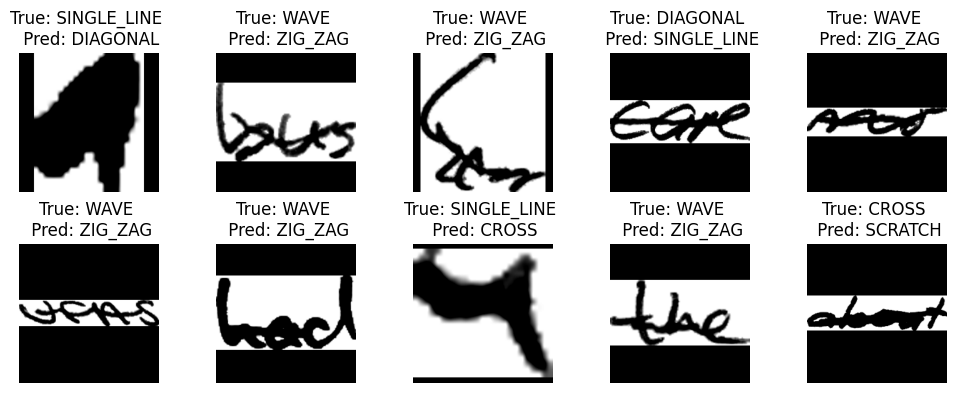

In [44]:
import matplotlib.pyplot as plt
import random
import torch

# Example: List of image tensors (assuming each tensor is of shape [3, H, W])

image_and_label = tuple(zip(missed_image,wrong_guess,correct_label))
# Select 10 random images

random_images = random.sample(image_and_label, 10)
classes = ["CLEAN","CROSS","DIAGONAL","DOUBLE_LINE","SCRATCH","SINGLE_LINE","WAVE","ZIG_ZAG"]
# Plot images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, img_label in enumerate(random_images):
    img, guess, label = img_label
    ax = axes[i // 5, i % 5]
    ax.imshow(img.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for visualization
    ax.set_title(f"True: {classes[label]} \n Pred: {classes[guess]}", fontsize=12)
    ax.axis("off")  # Hide axes
    

plt.tight_layout()
plt.show()

In [41]:
import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model safely
model = torch.load(
    "Baseline_ResNet18_20x20.pth",
    map_location=device,
    weights_only=False
)
model.to(device)
model.eval()

num_classes = 8
# Initialize confusion matrix
conf_matrix = torch.zeros(num_classes, num_classes, device=device)
total = 0
correct = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
        inputs, labels = batch
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        for t, p in zip(labels, preds):
            if t < num_classes and p < num_classes:
                conf_matrix[t, p] += 1
                if t == p:
                    correct += 1
            total += 1

# Calculate overall accuracy
total_accuracy = 100 * correct / total
print(f"\nTotal Accuracy: {total_accuracy:.2f}%\n")

# Convert confusion matrix to % per class
conf_matrix_cpu = conf_matrix.to("cpu")
conf_percent = conf_matrix_cpu.clone()
for i in range(num_classes):
    row_sum = conf_percent[i].sum()
    if row_sum > 0:
        conf_percent[i] = conf_percent[i] / row_sum * 100

# Create and format the confusion DataFrame
columns = [f"Pred_{i}" for i in range(num_classes)]
index = [f"True_{i}" for i in range(num_classes)]
df = pd.DataFrame(conf_percent.numpy(), index=index, columns=columns)
df = df.round(2)

# Show results
print("Confusion Matrix (% per true class):")
print(df.to_string())
print(conf_matrix.tolist().to_string())

# --------------------------
# Compute Macro F1 Score
# --------------------------

TP = conf_matrix_cpu.diag()
FP = conf_matrix_cpu.sum(dim=0) - TP
FN = conf_matrix_cpu.sum(dim=1) - TP

# Avoid division by zero
precision = TP / (TP + FP + 1e-8)
recall = TP / (TP + FN + 1e-8)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

macro_f1 = f1.mean().item() * 100  # Multiply by 100 for %
print(f"\nMacro F1 Score: {macro_f1:.2f}%")


Using device: cuda


Evaluating: 100%|██████████| 2360/2360 [01:52<00:00, 20.92batch/s]



Total Accuracy: 99.47%

Confusion Matrix (% per true class):
           Pred_0     Pred_1     Pred_2     Pred_3     Pred_4     Pred_5     Pred_6     Pred_7
True_0  99.980003   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
True_1   0.000000  99.730003   0.110000   0.100000   0.010000   0.050000   0.000000   0.010000
True_2   0.000000   0.080000  99.739998   0.010000   0.010000   0.140000   0.010000   0.020000
True_3   0.000000   0.050000   0.010000  99.769997   0.010000   0.150000   0.010000   0.000000
True_4   0.020000   0.010000   0.000000   0.020000  99.910004   0.000000   0.010000   0.050000
True_5   0.010000   0.100000   0.070000   0.270000   0.010000  99.519997   0.010000   0.020000
True_6   0.010000   0.010000   0.000000   0.010000   0.000000   0.040000  98.309998   1.630000
True_7   0.010000   0.010000   0.030000   0.020000   0.000000   0.060000   1.230000  98.650002


AttributeError: 'list' object has no attribute 'to_string'

In [44]:
conf_matrix_cpu = conf_matrix.to("cpu")
df = pd.DataFrame(conf_matrix.cpu().int().numpy(), index=index, columns=columns)
print(df.to_string())

        Pred_0  Pred_1  Pred_2  Pred_3  Pred_4  Pred_5  Pred_6  Pred_7
True_0   23187       0       0       1       1       1       1       0
True_1       0   18213      20      18       1      10       0       1
True_2       0      14   18216       2       1      26       1       3
True_3       0       9       1   18221       2      28       2       0
True_4       3       1       0       3   18246       0       1       9
True_5       1      19      12      49       1   18176       1       4
True_6       2       1       0       1       0       7   17955     297
True_7       1       1       5       4       0      11     225   18016
